# Sea Ice Indicators Update: Trend analysis

##### 2021-05-21

This update presents various analyses of trends of sea ice over time.

**Note** - I will again refer to "our" method as the "J&E" algorithm/indicators (Johnson & Eicken) and the NSIDC-0747 data/algorithm will be the "Steele" indicators. 

## 2021-05-07 update ice season length follow-up

In my meeting with John to discuss the 2021-05-07 "summary" update, he pointed out that the Steele indicator ice season length maps look inverted. Here is a quick follow-up to that: this was due to a bug in my code that was using an "undefined" masking array to set values to 0 for display purposes instead of the landmask array. 

Here are the same ice season length maps with a corrected version of the Steele indicators ice season length maps shown below.

In [2]:
import os
os.environ["BASE_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/"

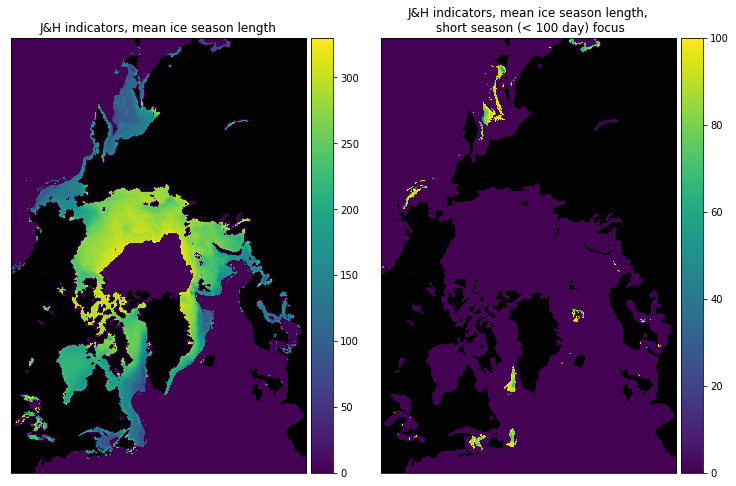

In [699]:
import copy
import os
import warnings
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path


def plot_season_length(ds, titles, landmask=None):
    """Count valid dates by metric and plot"""
    if "freezeup_start" in list(ds.variables):
        season_lengths = (ds["breakup_end"].values + 365) - ds["freezeup_start"].values
    else:
        # calculate ice season length for NSIDC-0747 data as
        # day of retreat minus day of advance
        dor = ds["DOR"].values.copy()
        doa = ds["DOA"].values.copy()
        invalid_mask = dor < 0
        undefined_mask = dor == 0
        dor += 365
        dor[(invalid_mask | undefined_mask)] = np.nan
        doa[(invalid_mask | undefined_mask)] = np.nan
        season_lengths = dor - doa
        landmask = ds["DOA"].values[0] == -4
        pole_sea_mask = (ds["DOA"].values == -5) | (ds["DOA"].values == -1)
        season_lengths[(pole_sea_mask | landmask)] = 0
        
    length_arrs = np.array([season_lengths, season_lengths])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        plot_arrs = np.nanmean(length_arrs, 1)
        
    filter_max = 100
    plot_arrs[1][plot_arrs[1] >= filter_max] = 0
    plot_arrs[np.isnan(plot_arrs)] = 0
    plot_arrs = [np.ma.masked_where(landmask, arr) for arr in plot_arrs]
        
    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="black")
    fig, axs = plt.subplots(1, 2, figsize=(14,8))
    fig.subplots_adjust(wspace=-0.1)
    for arr,ax,title,vmax in zip(plot_arrs, axs, titles, [330, 100]):
        arr.data[arr.mask] = np.nan
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=0, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=False)
        fig.colorbar(im, ax=cax)
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
    return plot_arrs

base_dir = Path(os.getenv("BASE_DIR"))
# computed fubu dates fp
fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")
# path to sample converted file to get landmask array
converted_fp = list(base_dir.joinpath("nsidc_0051/prepped").glob("*"))[0]

# load fubu dates netCDF
# set up meta data for saving GeoTIFFs
with rio.open(converted_fp) as src:
    # defined for global reference
    landmask = src.read(1) == 254
    # meta = src.meta

fubu_ds = xr.load_dataset(fubu_fp)

orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")
orac_ds = xr.load_dataset(orac_fp)

titles = ["J&H indicators, mean ice season length", "J&H indicators, mean ice season length,\n short season (< 100 day) focus"]
fubu_isl_arrs = plot_season_length(fubu_ds, titles, landmask)

*Steele indicators* 

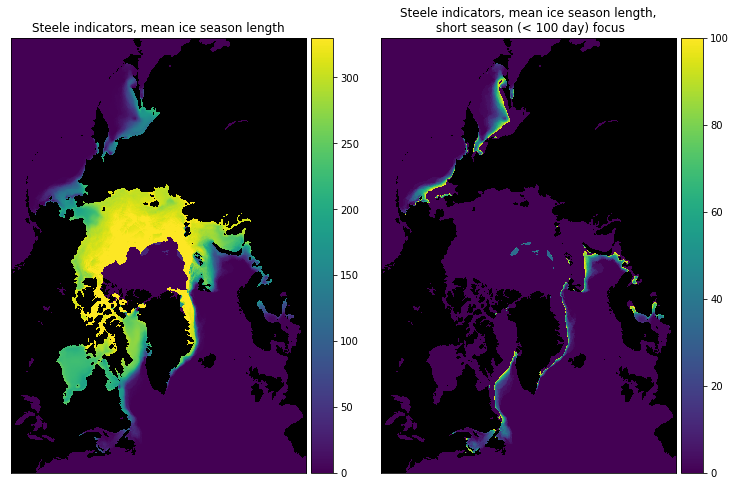

In [700]:
titles = ["Steele indicators, mean ice season length", "Steele indicators, mean ice season length,\n short season (< 100 day) focus"]
temp = plot_season_length(orac_ds, titles)

## Trend analysis

### Point locations

For each point location, indicator dates of adjacent pixels to those overlapping the point that were not intersecting the coastline were averaged and the resulting mean date was regressed against year.

#### Utqiaġvik

Here is the map of the pixels used for the analysis of trends near Utqiaġvik:

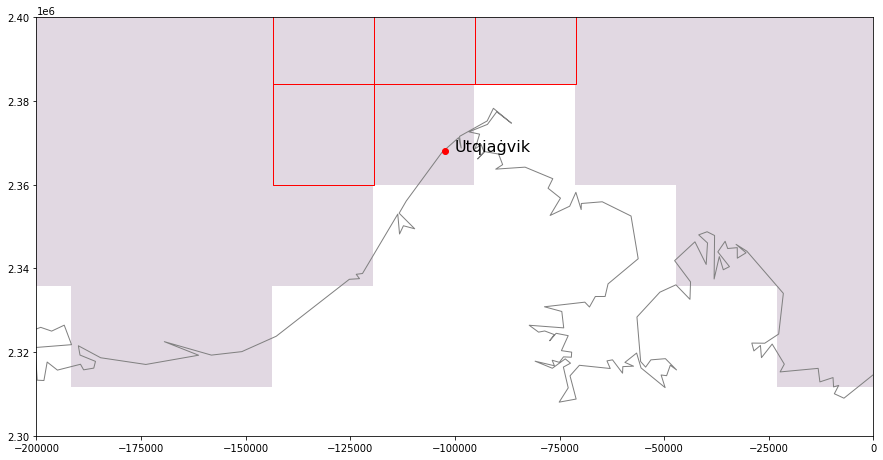

In [695]:
import seaborn as sns
from rasterstats import zonal_stats
from shapely.geometry import Polygon
import rioxarray
import geopandas as gpd
from rasterio import plot
from pyproj import Transformer, crs


def get_xy_from_coords(fp, x, y, offsets):
    """shift is a list of tuples correpsonding to 
    a single pixel of interest (poi), each tuple contains
    the index shift from the base pixel to the poi
    as (x shift, y shift)
    
    returns list of center points of pixels corresponding
    to the offsets
    """
    row, col = src.index(x, y)

    return [src.xy(row + offset[0], col + offset[1]) for offset in offsets]

    
def make_pixel_polygon_from_xy(transform, x, y):
    """Make polygon corresponding to raster pixels
    from given xy centerpoint and the raster's Affine transform
    """
    res = transform[0]
    ul = (x - (res / 2), y + (res / 2))
    corner_list = [
        ul,
        (ul[0] + res, ul[1]),
        (ul[0] + res, ul[1] - res),
        (ul[0], ul[1] - res),
        ul,
    ]
    return Polygon([corner for corner in corner_list])
    
    
def make_pixel_poly_gdf(transform, xy_list):
    """make GeoPandas DF of pixel polygons from xy list and transform"""
    polys = [make_pixel_polygon_from_xy(transform, *xy) for xy in xy_list]
    return gpd.GeoDataFrame(geometry=polys)


fubu_3411 = fubu_ds.rio.write_crs("EPSG:3411")
fubu_3338 = fubu_3411.rio.set_spatial_dims("xc", "yc").rio.reproject("EPSG:3338")

# use this shapefile instead
world_shore = gpd.read_file("/atlas_scratch/kmredilla/seaice_noaa_indicators/GSHHS_shp/i/GSHHS_i_L1.shp")
world_shore = world_shore.to_crs(epsg=3338)

# create seamask
doa = copy.deepcopy(orac_ds["DOA"])
doa = doa.sel(time=doa["time"].values[0])
doa.values[doa.values != -4] = 0
doa.values[doa.values == -4] = np.nan
doa = doa.rio.write_crs("EPSG:3411").rio.set_spatial_dims("x", "y").rio.reproject("EPSG:3338")
seamask_fp = "/atlas_scratch/kmredilla/seaice_noaa_indicators/steele_seamask.tif"
doa.rio.to_raster(seamask_fp)

transformer = Transformer.from_crs(4326, 3338, always_xy=True)
x,y = transformer.transform(-156.788838, 71.289736)

with rio.open(seamask_fp) as src:
    fig, ax = plt.subplots(figsize=(15, 15))
    plot.show(src, ax=ax, vmax=10000, cmap="twilight")
    world_shore.set_index("id").loc[["2"]].plot(ax=ax, facecolor='none', edgecolor="gray")
    ax.set_xlim([-200000, 0])
    ax.set_ylim([2300000, 2400000])
    ax.scatter(x, y, color="red")
    ax.text(-100000, 2368030, "Utqiaġvik", size=16)
    
    # plot cells that will be used
    xy_list = get_xy_from_coords(src, x, y, [(0, -1), (-1, -1), (-1, 0), (-1, 1)])
    polys = make_pixel_poly_gdf(src.transform, xy_list)
    polys.plot(ax=ax, facecolor='none', edgecolor="red")
    

And the trends, first for the J&H Indicators:

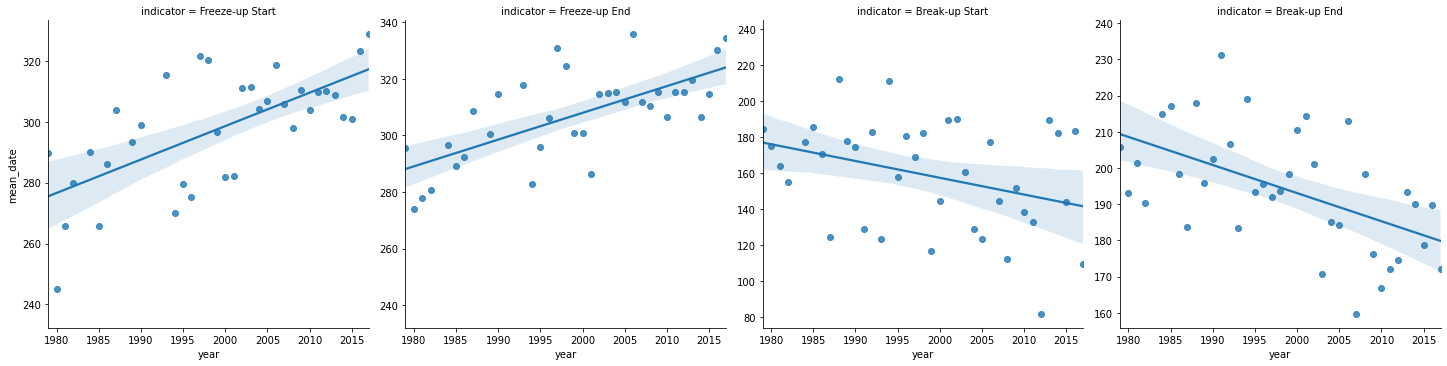

In [504]:
import seaborn as sns


def make_df_from_xy(ds, var_dict, xy_list, group):
    """given an xy_list and variables, make a dataframe by querying an 
    xarray dataset at the given xy locations and aggregating via mean
    """
    # empty list for holding DFs
    df_list = []
    # make a data frame for a single dataset and variable
    with warnings.catch_warnings():
        # ignore "mean of empty slice" warnings
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for var in var_dict.keys():
            df_list.append(
                pd.DataFrame.from_dict(
                    {
                        "indicator": var_dict[var],
                        "year": ds["year"].values,
                        "mean_date": np.nanmean(
                            np.array([
                                ds[var].sel(x=xy[0], y=xy[1], method="nearest").values 
                                for xy in xy_list
                            ]), axis=0),
                        "group": group,
                    }
                )
            )
        
    return pd.concat(df_list)


fubu_vars = {
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
    "breakup_start": "Break-up Start",
    "breakup_end": "Break-up End",
}

fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
fubu_df = fubu_df[fubu_df["year"] <= 2017]

sns.lmplot(x="year", y="mean_date", col="indicator", data=fubu_df, sharey=False)
plt.show()

And for the Steele indicators:

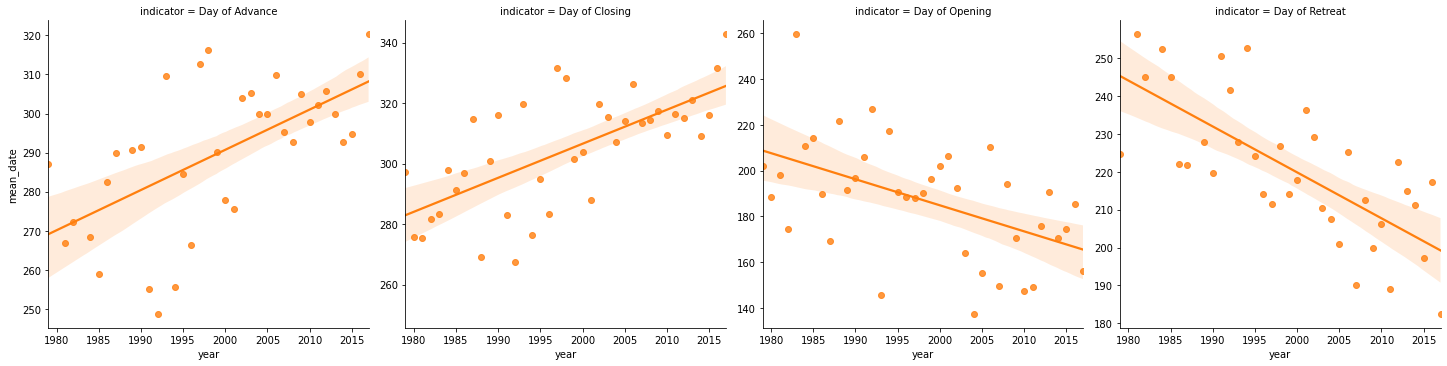

In [505]:
# first, get stats using dataframes for each algorithm
from scipy import stats

def get_linreg_results_df(indicators_df, group, loc):
    rows = []
    for indicator, df in indicators_df.groupby(["indicator"]):
        df = df[~np.isnan(df["mean_date"])]
        slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
        rows.append([loc, group, indicator, round(slope, 1), round(r_value, 2), round(p_value, 3)])
        
    return pd.DataFrame(rows, columns=["location", "group", "indicator", "slope", "r_squared", "p_value"])


orac_vars = {
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
    "DOO": "Day of Opening",
    "DOR": "Day of Retreat",
}

# keep only orac vars, throws error with projection var
# set values to np.nan for reprojection 

orac_3411 = orac_ds[list(orac_vars.keys())].copy()
for var in orac_vars:
    orac_3411[var].values[orac_3411[var].values < 1] = np.nan 

orac_3411 = orac_3411.rio.write_crs("EPSG:3411").rio.set_spatial_dims("x", "y")
orac_3338 = orac_3411.rio.reproject("EPSG:3338")
# need to restructure for consistent year df
years = np.array([dt.year for dt in orac_3338["time"].values])
orac_3338 = orac_3338.assign_coords(time=years).rename_vars({"time": "year"})

orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")

fubu_results = get_linreg_results_df(fubu_df, "J&H", "Utqiaġvik")
orac_results = get_linreg_results_df(orac_df, "Steele", "Utqiaġvik")

# then use seaborn for plotting
sns.lmplot(x="year", y="mean_date", col="indicator", data=orac_df, sharey=False, line_kws={"color": "#ff7f0e"}, scatter_kws={"color": "#ff7f0e"})
plt.show()

And with both indicators on the same plots:

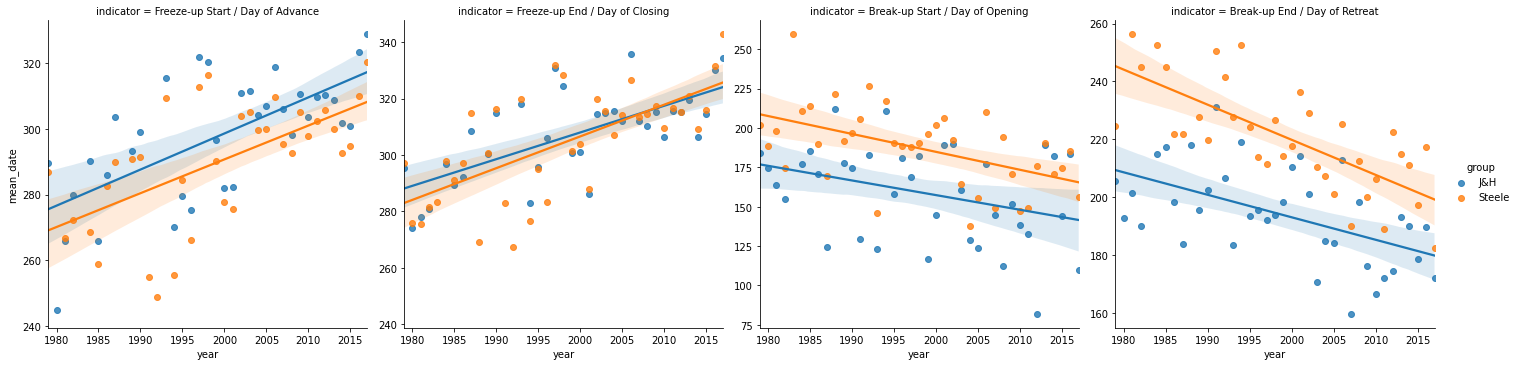

In [506]:
fubu_vars = {
    "freezeup_start": "Freeze-up Start / Day of Advance", 
    "freezeup_end": "Freeze-up End / Day of Closing", 
    "breakup_start": "Break-up Start / Day of Opening",
    "breakup_end": "Break-up End / Day of Retreat",
}
orac_vars = {
    "DOA": "Freeze-up Start / Day of Advance", 
    "DOC": "Freeze-up End / Day of Closing", 
    "DOO": "Break-up Start / Day of Opening",
    "DOR": "Break-up End / Day of Retreat",
}


fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")
fubu_df = fubu_df[fubu_df["year"] <= 2017]

df = fubu_df.append(orac_df)

sns.lmplot(x="year", y="mean_date", col="indicator", hue="group", data=df, sharey=False)
plt.show()

#### (North of) Bering Strait

Here is the map of the pixels used for the analysis of trends in the Bering Strait:

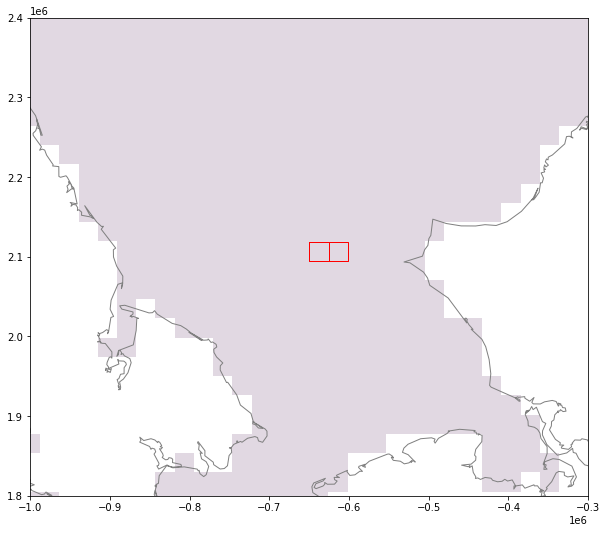

In [511]:
x,y = transformer.transform(-169, 68.34238)

with rio.open(seamask_fp) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    plot.show(src, ax=ax, vmax=10000, cmap="twilight")
    #ids 2
    world_shore.set_index("id").loc[["0-W"]].plot(ax=ax, facecolor='none', edgecolor="gray")
    world_shore.set_index("id").loc[["2"]].plot(ax=ax, facecolor='none', edgecolor="gray")
    ax.set_xlim([-1000000, -300000])
    ax.set_ylim([1800000, 2400000])
    
    # plot cells that will be used
    xy_list = get_xy_from_coords(src, x, y, [(0, 0), (0, -1)])
    polys = make_pixel_poly_gdf(src.transform, xy_list)
    polys.plot(ax=ax, facecolor='none', edgecolor="red")

J&H trends:

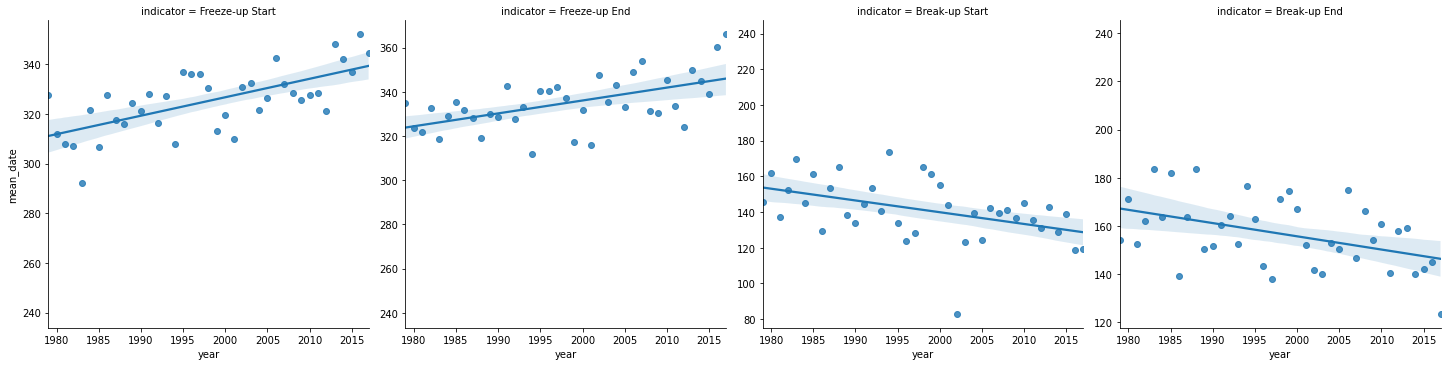

In [512]:
fubu_vars = {
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
    "breakup_start": "Break-up Start",
    "breakup_end": "Break-up End",
}

fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
fubu_df = fubu_df[fubu_df["year"] <= 2017]

sns.lmplot(x="year", y="mean_date", col="indicator", data=fubu_df, sharey=False)
plt.show()

Steele trends:

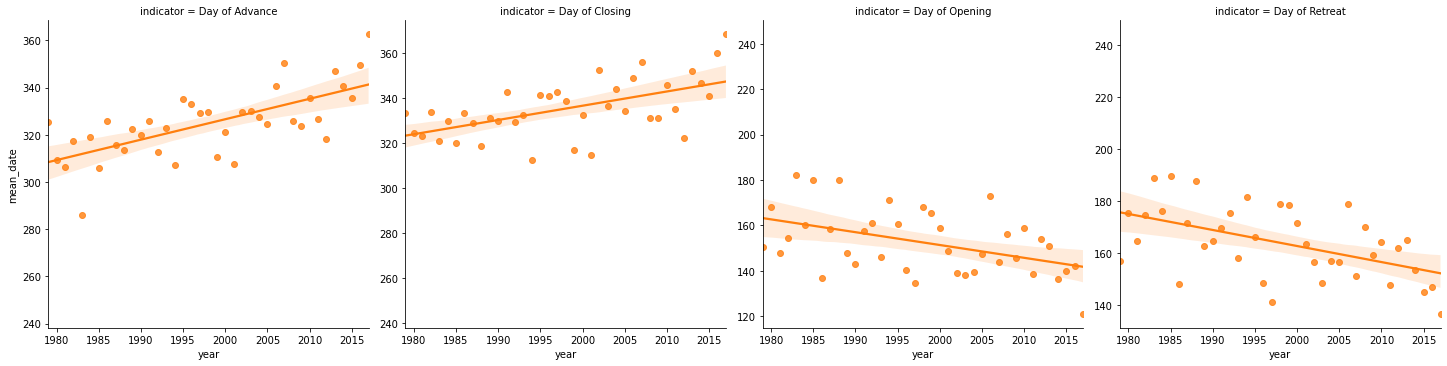

In [513]:
orac_vars = {
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
    "DOO": "Day of Opening",
    "DOR": "Day of Retreat",
}

orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")


fubu_results = fubu_results.append(get_linreg_results_df(fubu_df, "J&H", "Bering Strait"))
orac_results = orac_results.append(get_linreg_results_df(orac_df, "Steele", "Bering Strait"))

sns.lmplot(x="year", y="mean_date", col="indicator", data=orac_df, sharey=False, line_kws={"color": "#ff7f0e"}, scatter_kws={"color": "#ff7f0e"})
plt.show()

J&H + Steele trends

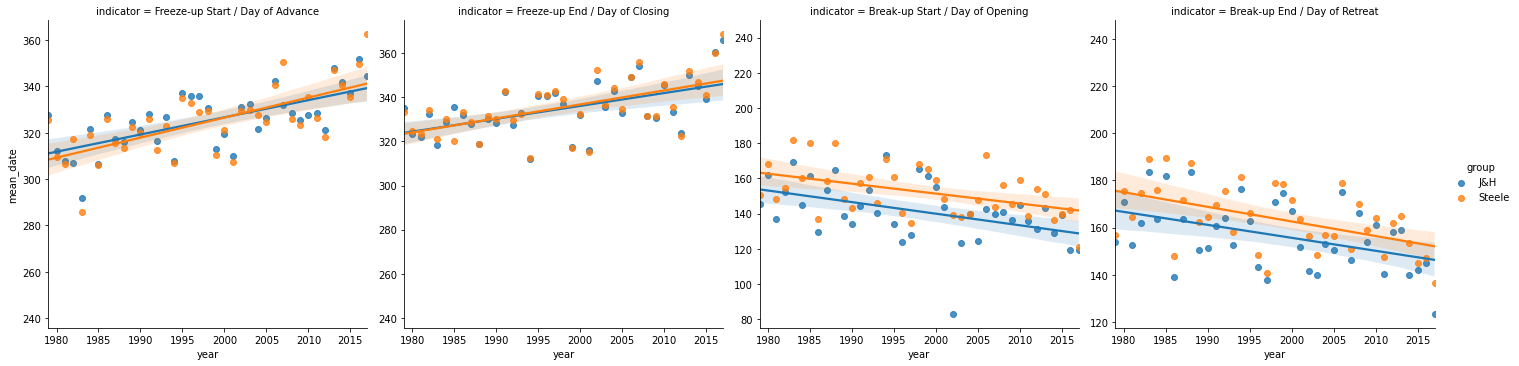

In [514]:
fubu_vars = {
    "freezeup_start": "Freeze-up Start / Day of Advance", 
    "freezeup_end": "Freeze-up End / Day of Closing", 
    "breakup_start": "Break-up Start / Day of Opening",
    "breakup_end": "Break-up End / Day of Retreat",
}
orac_vars = {
    "DOA": "Freeze-up Start / Day of Advance", 
    "DOC": "Freeze-up End / Day of Closing", 
    "DOO": "Break-up Start / Day of Opening",
    "DOR": "Break-up End / Day of Retreat",
}


fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")
fubu_df = fubu_df[fubu_df["year"] <= 2017]

df = fubu_df.append(orac_df)

sns.lmplot(x="year", y="mean_date", col="indicator", hue="group", data=df, sharey=False)
plt.show()

#### St. Lawrence Island

Here is the map of the pixels used for the analysis of trends south of St. Lawrence Island (for a few cells south of the Island):

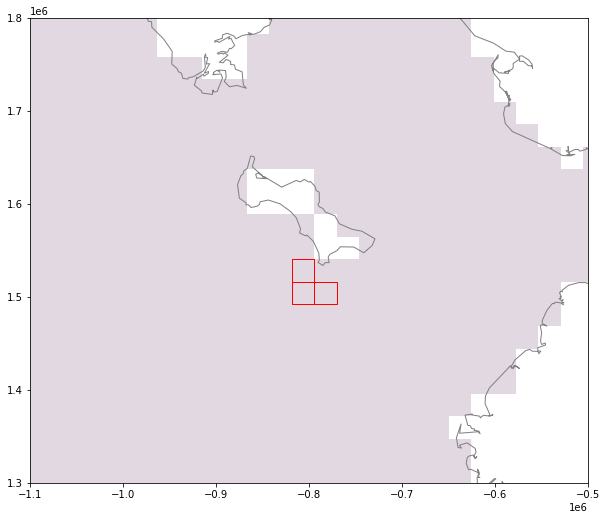

In [515]:
x,y = transformer.transform(-169.912708, 62.859820)

with rio.open(seamask_fp) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    plot.show(src, ax=ax, vmax=10000, cmap="twilight")
    #ids 2
    world_shore.set_index("id").loc[["0-W"]].plot(ax=ax, facecolor='none', edgecolor="gray")
    world_shore.set_index("id").loc[["2"]].plot(ax=ax, facecolor='none', edgecolor="gray")
    # St Lawrence Island
    world_shore.set_index("id").loc[["125"]].plot(ax=ax, facecolor='none', edgecolor="gray")
    ax.set_xlim([-1100000, -500000])
    ax.set_ylim([1300000, 1800000])
    
    # plot cells that will be used
    xy_list = get_xy_from_coords(src, x, y, [(0, 0), (1, 0), (1, 1)])
    polys = make_pixel_poly_gdf(src.transform, xy_list)
    polys.plot(ax=ax, facecolor='none', edgecolor="red")

J&H trends

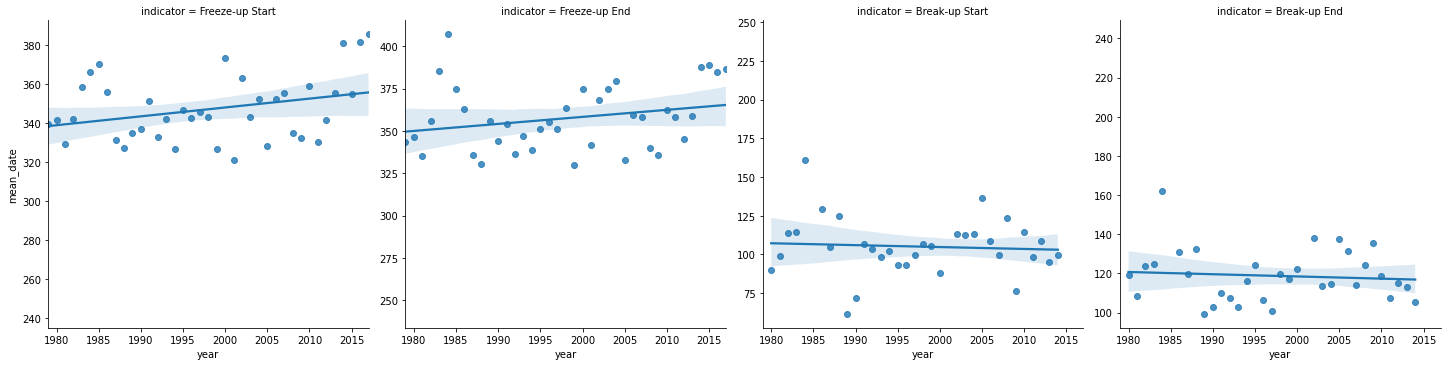

In [516]:
fubu_vars = {
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
    "breakup_start": "Break-up Start",
    "breakup_end": "Break-up End",
}

fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
fubu_df = fubu_df[fubu_df["year"] <= 2017]

sns.lmplot(x="year", y="mean_date", col="indicator", data=fubu_df, sharey=False)
plt.show()

Steele trends

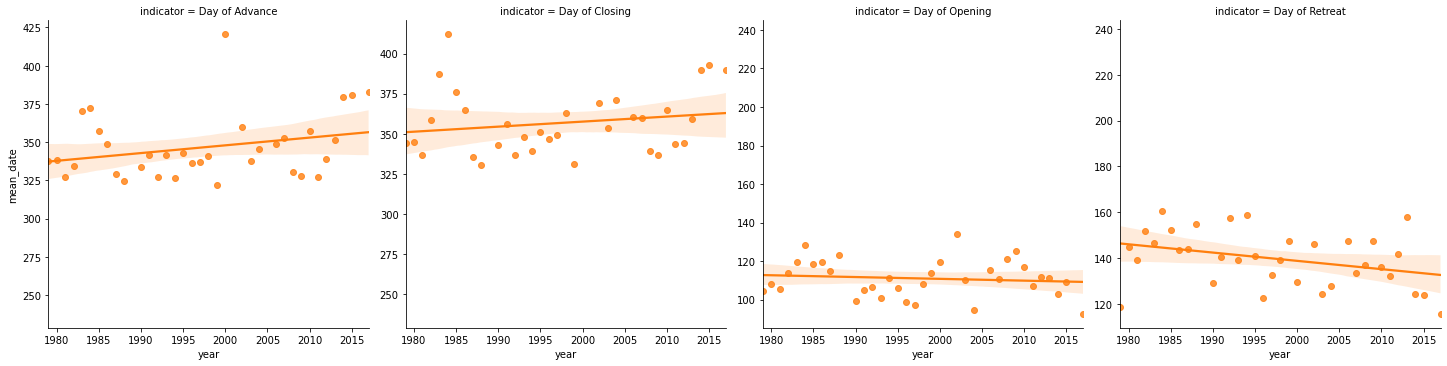

In [517]:
orac_vars = {
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
    "DOO": "Day of Opening",
    "DOR": "Day of Retreat",
}

orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")

fubu_results = fubu_results.append(get_linreg_results_df(fubu_df, "J&H", "St. Lawrence Island"))
orac_results = orac_results.append(get_linreg_results_df(orac_df, "Steele", "St. Lawrence Island"))

test = sns.lmplot(x="year", y="mean_date", col="indicator", data=orac_df, sharey=False, line_kws={"color": "#ff7f0e"}, scatter_kws={"color": "#ff7f0e"})
plt.show()

J&H + Steele trends

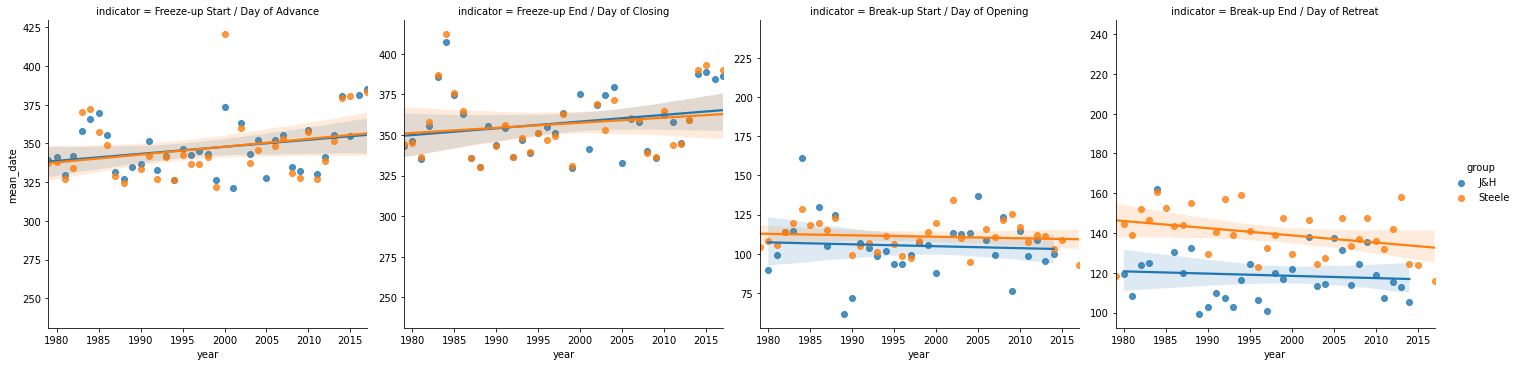

In [518]:
fubu_vars = {
    "freezeup_start": "Freeze-up Start / Day of Advance", 
    "freezeup_end": "Freeze-up End / Day of Closing", 
    "breakup_start": "Break-up Start / Day of Opening",
    "breakup_end": "Break-up End / Day of Retreat",
}
orac_vars = {
    "DOA": "Freeze-up Start / Day of Advance", 
    "DOC": "Freeze-up End / Day of Closing", 
    "DOO": "Break-up Start / Day of Opening",
    "DOR": "Break-up End / Day of Retreat",
}


fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")
fubu_df = fubu_df[fubu_df["year"] <= 2017]

df = fubu_df.append(orac_df)

sns.lmplot(x="year", y="mean_date", col="indicator", hue="group", data=df, sharey=False)
plt.show()

Here are the statistics from the above regressions:

In [519]:
fubu_results

,location,group,indicator,slope,r_squared,p_value
0,Utqiaġvik,J&H,Break-up End,-0.8,-0.53,0.001
1,Utqiaġvik,J&H,Break-up Start,-0.9,-0.35,0.032
2,Utqiaġvik,J&H,Freeze-up End,0.9,0.69,0.000
3,Utqiaġvik,J&H,Freeze-up Start,1.1,0.67,0.000
0,Bering Strait,J&H,Break-up End,-0.5,-0.44,0.005
1,Bering Strait,J&H,Break-up Start,-0.7,-0.44,0.005
2,Bering Strait,J&H,Freeze-up End,0.6,0.56,0.000
3,Bering Strait,J&H,Freeze-up Start,0.7,0.67,0.000
0,St. Lawrence Island,J&H,Break-up End,-0.1,-0.09,0.625
1,St. Lawrence Island,J&H,Break-up Start,-0.1,-0.07,0.704


In [520]:
orac_results

,location,group,indicator,slope,r_squared,p_value
0,Utqiaġvik,Steele,Day of Advance,1.0,0.61,0.000
1,Utqiaġvik,Steele,Day of Closing,1.1,0.68,0.000
2,Utqiaġvik,Steele,Day of Opening,-1.1,-0.51,0.001
3,Utqiaġvik,Steele,Day of Retreat,-1.2,-0.72,0.000
0,Bering Strait,Steele,Day of Advance,0.9,0.68,0.000
1,Bering Strait,Steele,Day of Closing,0.6,0.57,0.000
2,Bering Strait,Steele,Day of Opening,-0.6,-0.46,0.003
3,Bering Strait,Steele,Day of Retreat,-0.6,-0.52,0.001
0,St. Lawrence Island,Steele,Day of Advance,0.5,0.27,0.111
1,St. Lawrence Island,Steele,Day of Closing,0.3,0.18,0.300


### MAISE Regions

For each MAISE region, indicator dates were aggregated by mean for each year and regressed against year in a simple regression, in the same fashion as was done for the point locations.

Warning, lots of plots ahead. For now, I figured it best to just present all trends for all regions/indicators, and hopefully this can help us choose how we want to present these results. 

#### J&H Freeze-up Start

In [594]:
def get_polygon(row):
    """Create shapely polygon object from row of 
    alternating lat/lon coords
    """
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):
         
        if pd.isnull(value):
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)
            
    df = pd.DataFrame(df_di)
    
    return Polygon(list(zip(df.lon, df.lat)))

masie_fp = base_dir.joinpath("ancillary/MASIE_regions_polygon_vertices.xls")

df = pd.read_excel(masie_fp, skiprows=1)

polys = df[["Region Number Identifier", "Name"]].copy()
for index, row in df.iterrows(): 
    polys.loc[index, "geometry"] = get_polygon(row)

polys = gpd.GeoDataFrame(polys).set_crs(epsg=4326).to_crs(epsg=3338)

with rio.open(seamask_fp) as src:
    affine = src.meta["transform"]

def nanmean(arr):
    return np.nanmean(arr)
    
# compute means for all regions / variables
zs = {"J&H": {}, "Steele": {}}
for group, ds in zip(zs.keys(), [fubu_3338, orac_3338]):
    for variable in list(ds.variables)[-4:]:
        zs[group][variable] = [
            zonal_stats(
                polys, 
                arr, 
                affine=affine,
                nodata=np.nan, 
                stats=["mean"],
                #add_stats={"nanmean": nanmean}
            ) 
            for arr in ds[variable].values
        ]
        
        all_year_series = []
        for year_means, year in zip(zs[group][variable], ds["year"].values):
            if year > 2017:
                continue
            year_series = pd.Series({
                region_name: list(region_mean.values())[0] 
                for region_mean, region_name in zip(year_means, polys.Name)
            }, name = "mean_date")
            year_series.index.name = "region"
            year_df = year_series.reset_index()
            year_df["year"] = year
            year_df["indicator"] = variable
            year_df["group"] = group
            all_year_series.append(year_df)
        
        zs[group][variable] = pd.concat(all_year_series)


zs["J&H"] = pd.concat(zs["J&H"]).reset_index().drop(columns=["level_1", "level_0"])
zs["Steele"] = pd.concat(zs["Steele"]).reset_index().drop(columns=["level_1", "level_0"])
zs_df = pd.concat(zs).reset_index().drop(columns=["level_1", "level_0"])

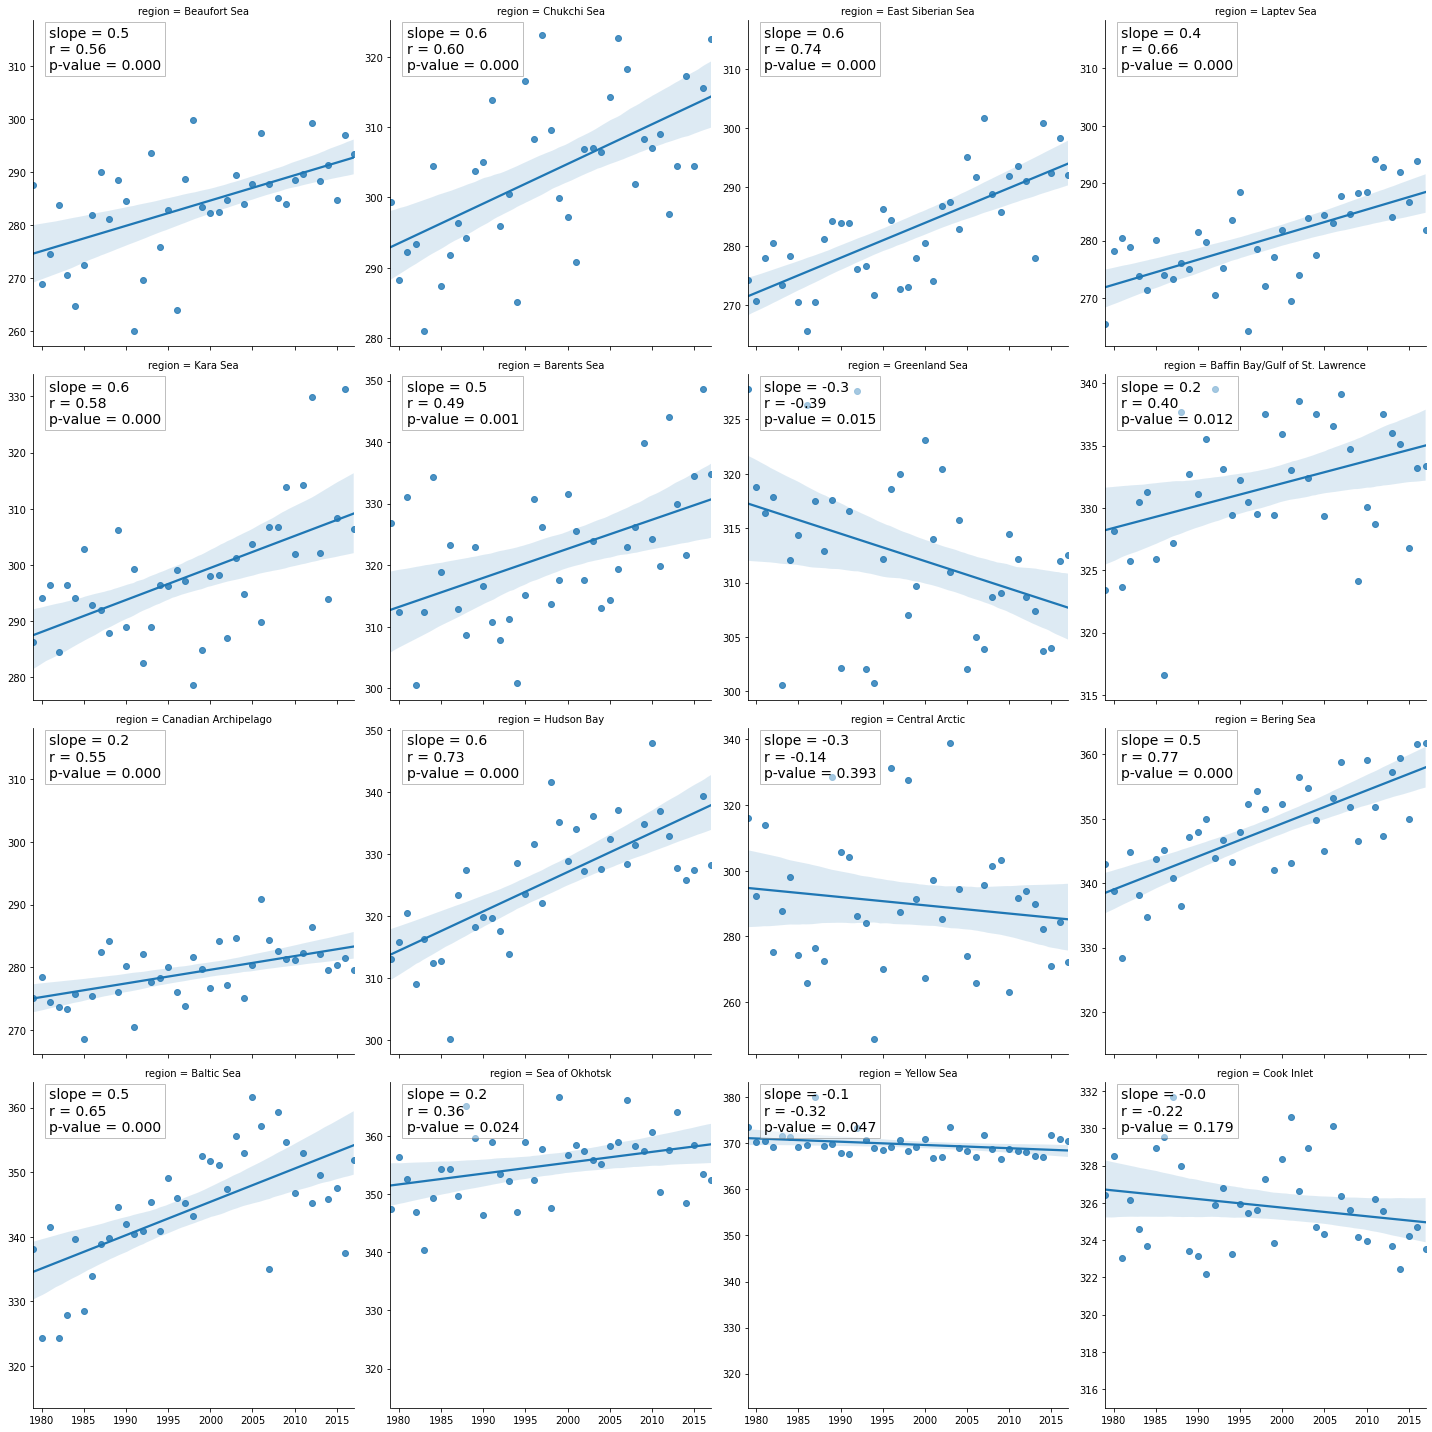

In [617]:
def get_linreg_results_df_maise(regions_df, group, indicator):
    rows = []
    for region, df in regions_df.groupby(["region"]):
        slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
        rows.append([region, group, indicator, round(slope, 1), round(r_value, 2), round(p_value, 3)])
        
    return pd.DataFrame(rows, columns=["region", "group", "indicator", "slope", "r_squared", "p_value"])


def lmplot_maise_with_stats(df, group, indicator, color="#1f77b4"):
    df = df[(df["group"] == group) & (df["indicator"] == indicator) & ~np.isnan(df["mean_date"])]
    
    g = sns.lmplot(x="year", y="mean_date", col="region", data=df, col_wrap=4, sharey=False, line_kws={"color": color}, scatter_kws={"color": color})
    
    def annotate(data, **kws):
        slope, intercept, r_value, p_value, std_err = stats.linregress(data["year"], data["mean_date"])
        ax = plt.gca()
        t = ax.text(
            .05, .85, 'slope = {:.1f}\nr = {:.2f}\np-value = {:.3f}'.format(slope, r_value, p_value), 
            transform=ax.transAxes,
            fontsize=14
        )
        t.set_bbox({"facecolor": "white", "alpha":0.5, "edgecolor":"gray"})

    g.map_dataframe(annotate)
    
    plt.show()
    
    return get_linreg_results_df_maise(df, group, indicator)
    
maise_results_df = []   
maise_results_df.append(lmplot_maise_with_stats(zs_df, "J&H", "freezeup_start"))

#### J&H Freeze-up End

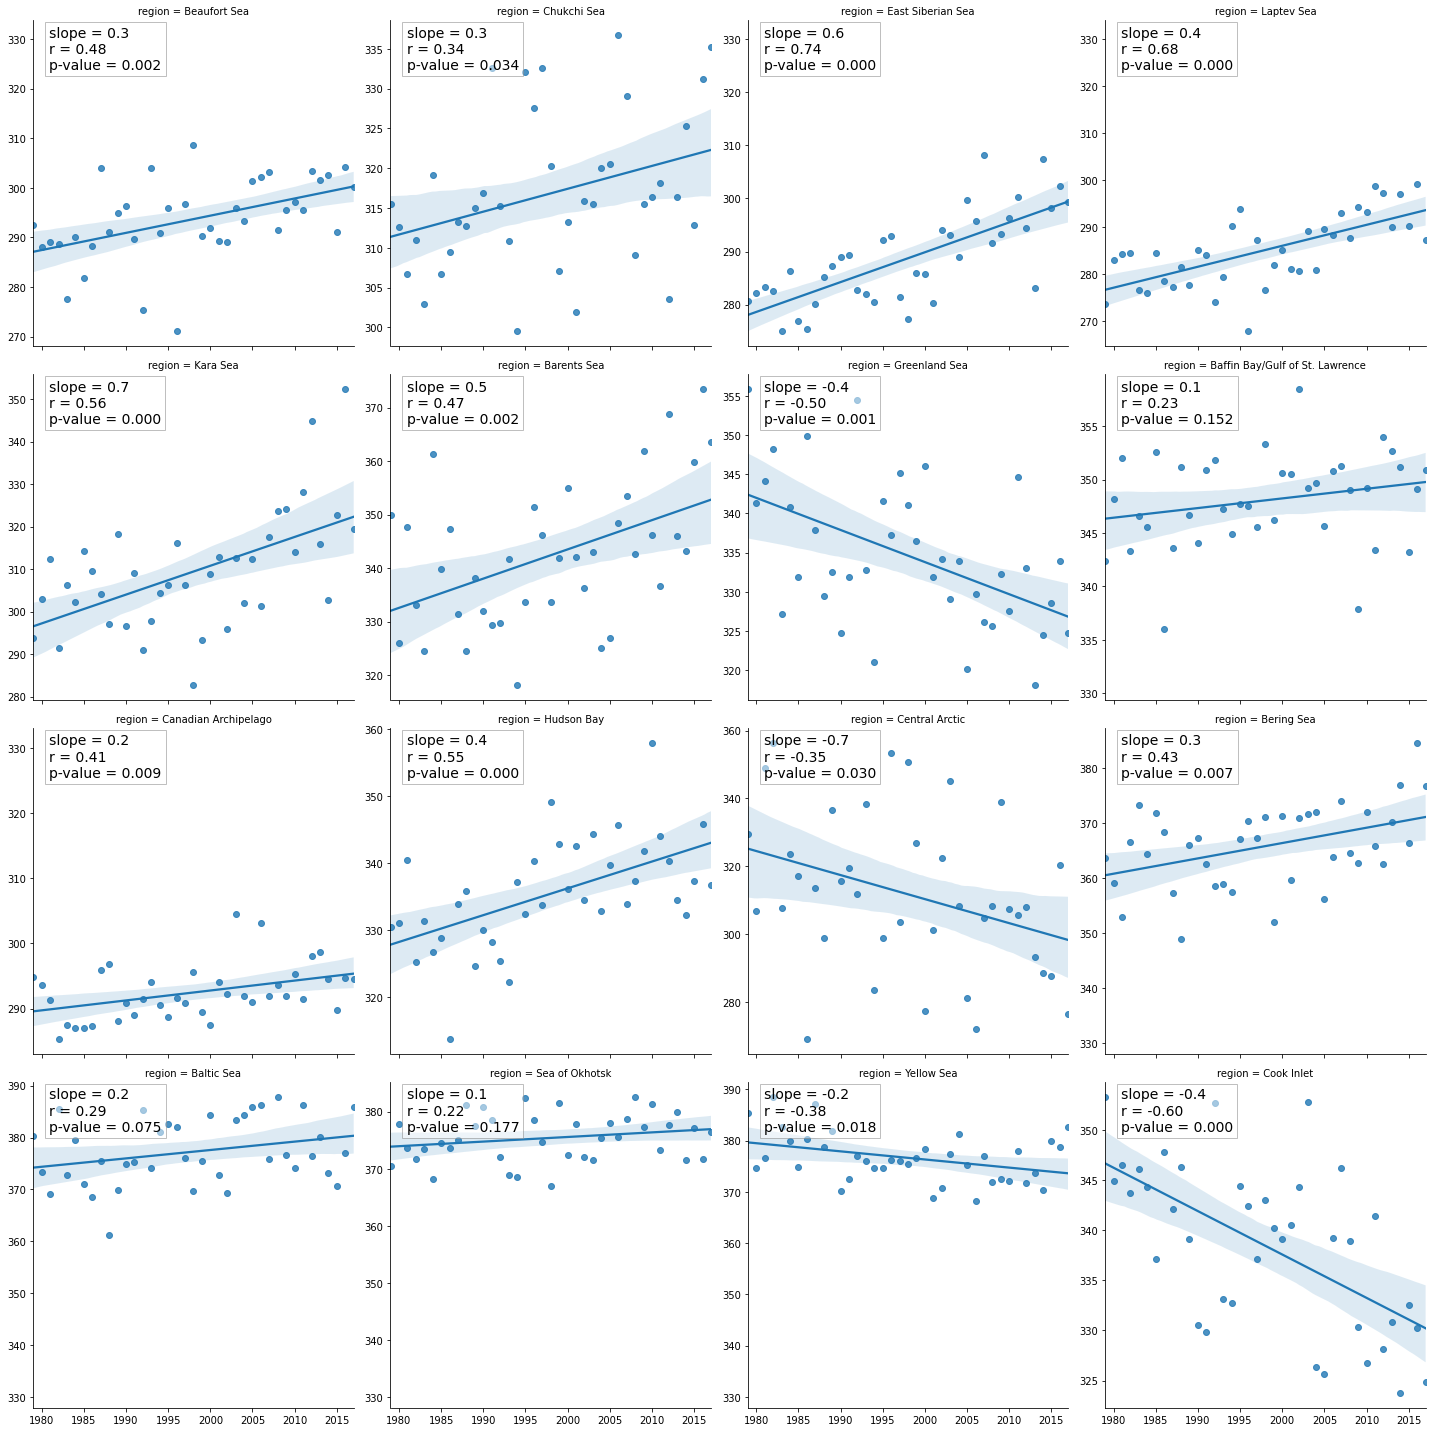

In [618]:
maise_results_df.append(lmplot_maise_with_stats(zs_df, "J&H", "freezeup_end"))

#### J&H Break-up Start

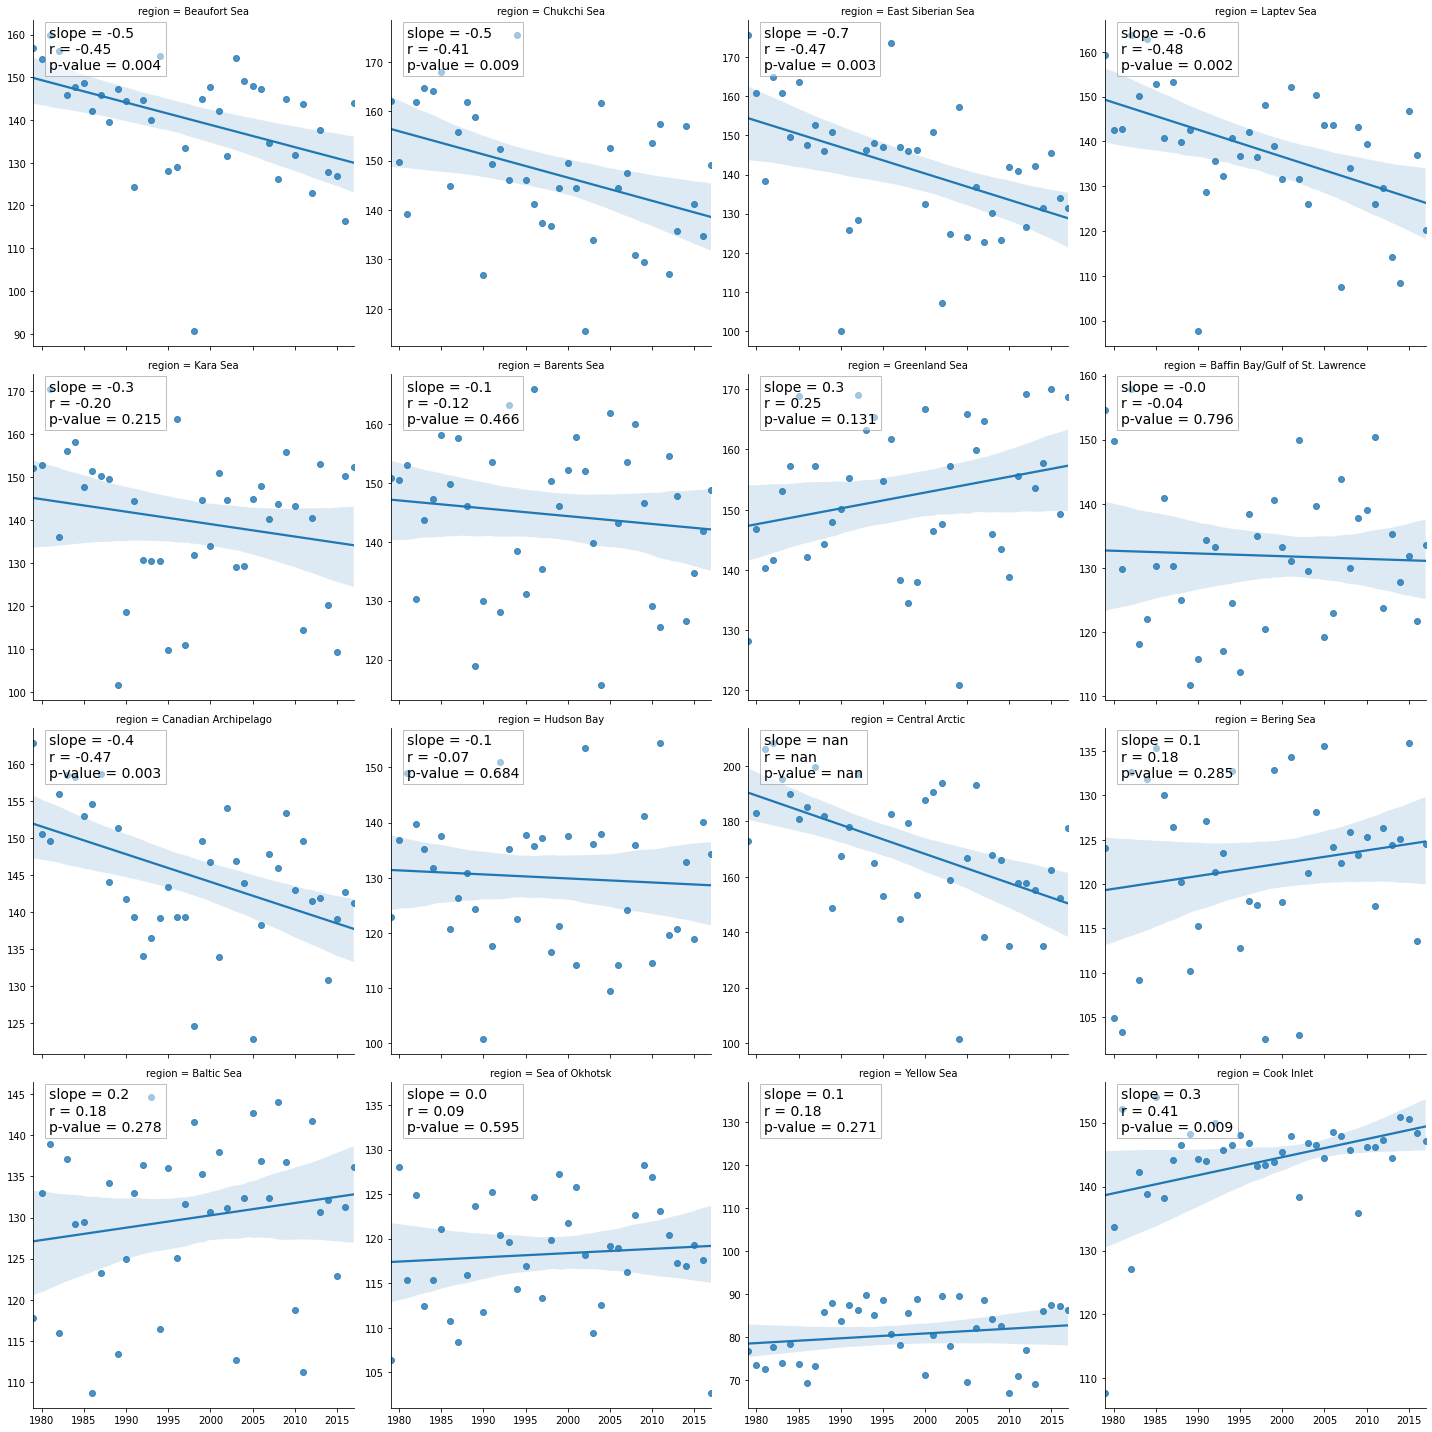

In [619]:
maise_results_df.append(lmplot_maise_with_stats(zs_df, "J&H", "breakup_start"))

#### J&H Break-up End

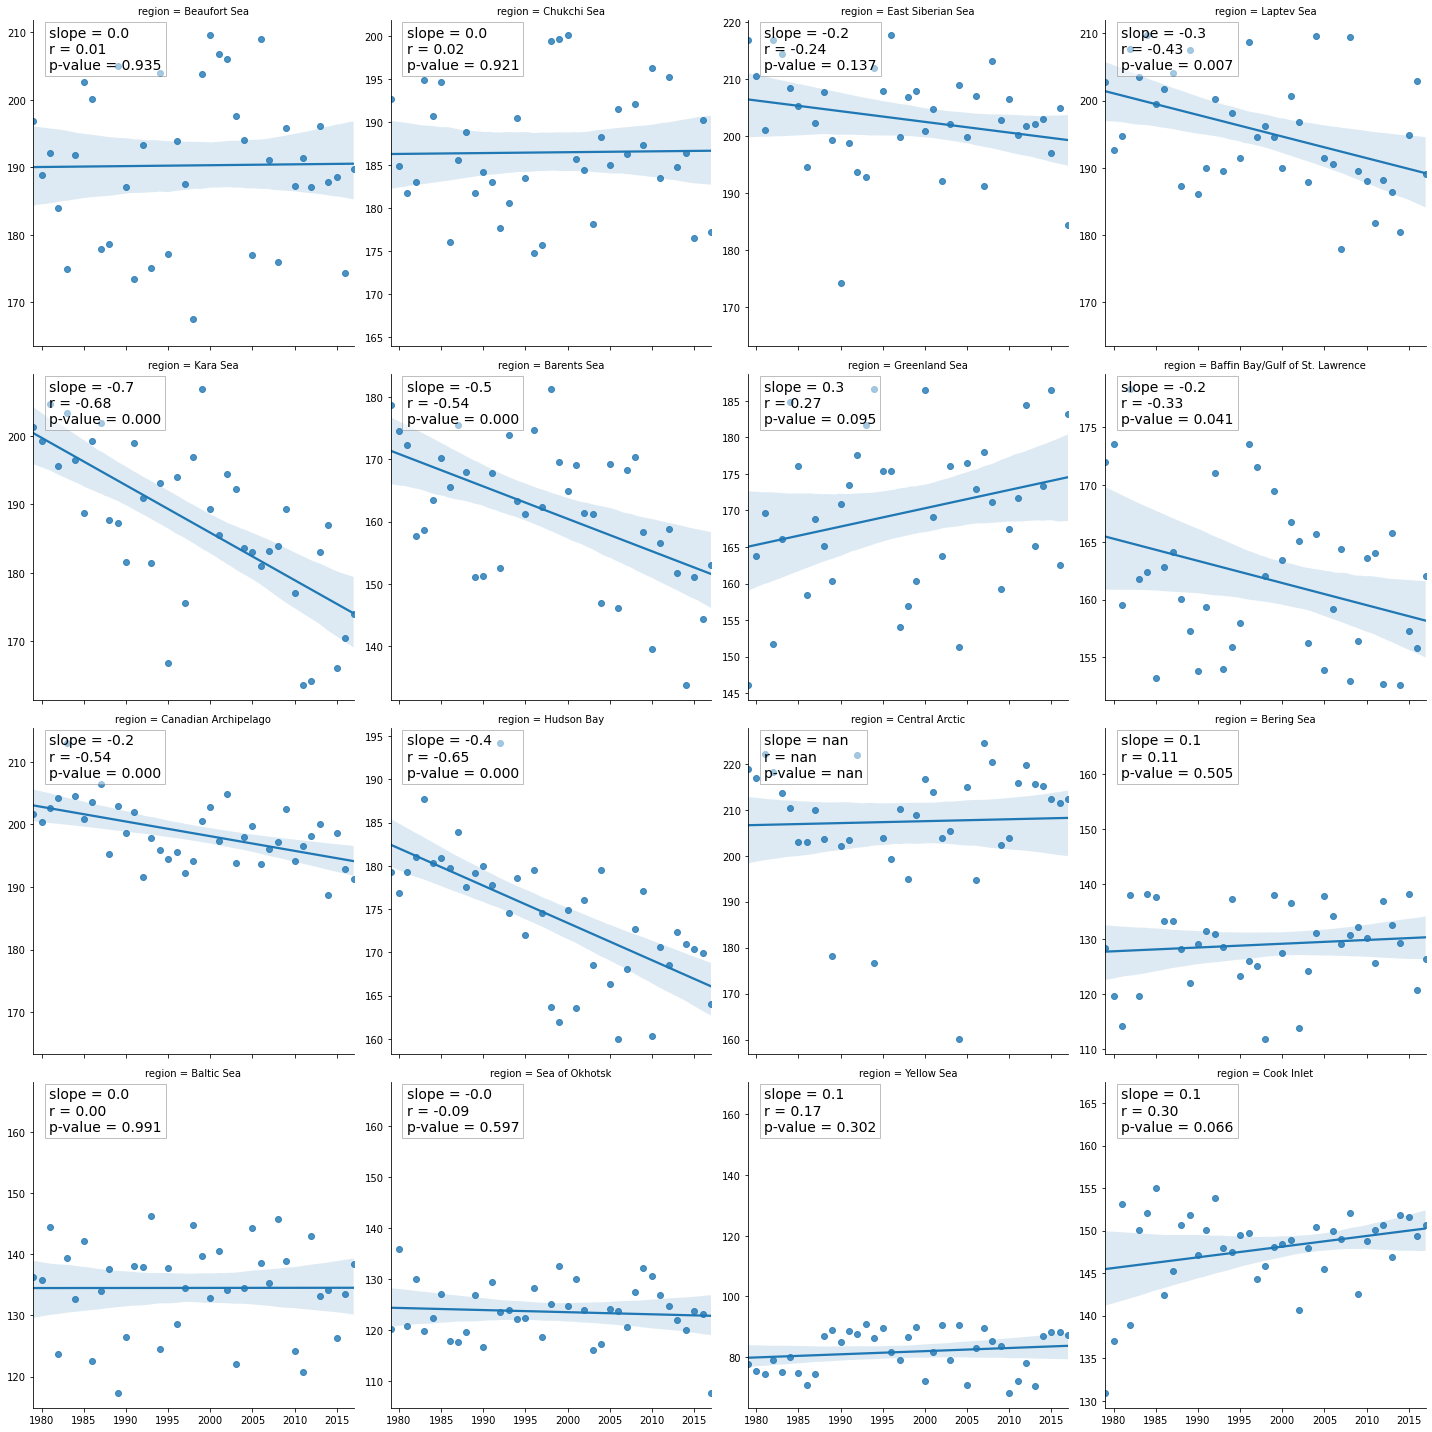

In [620]:
maise_results_df.append(lmplot_maise_with_stats(zs_df, "J&H", "breakup_end"))

#### Steele Day of Advance

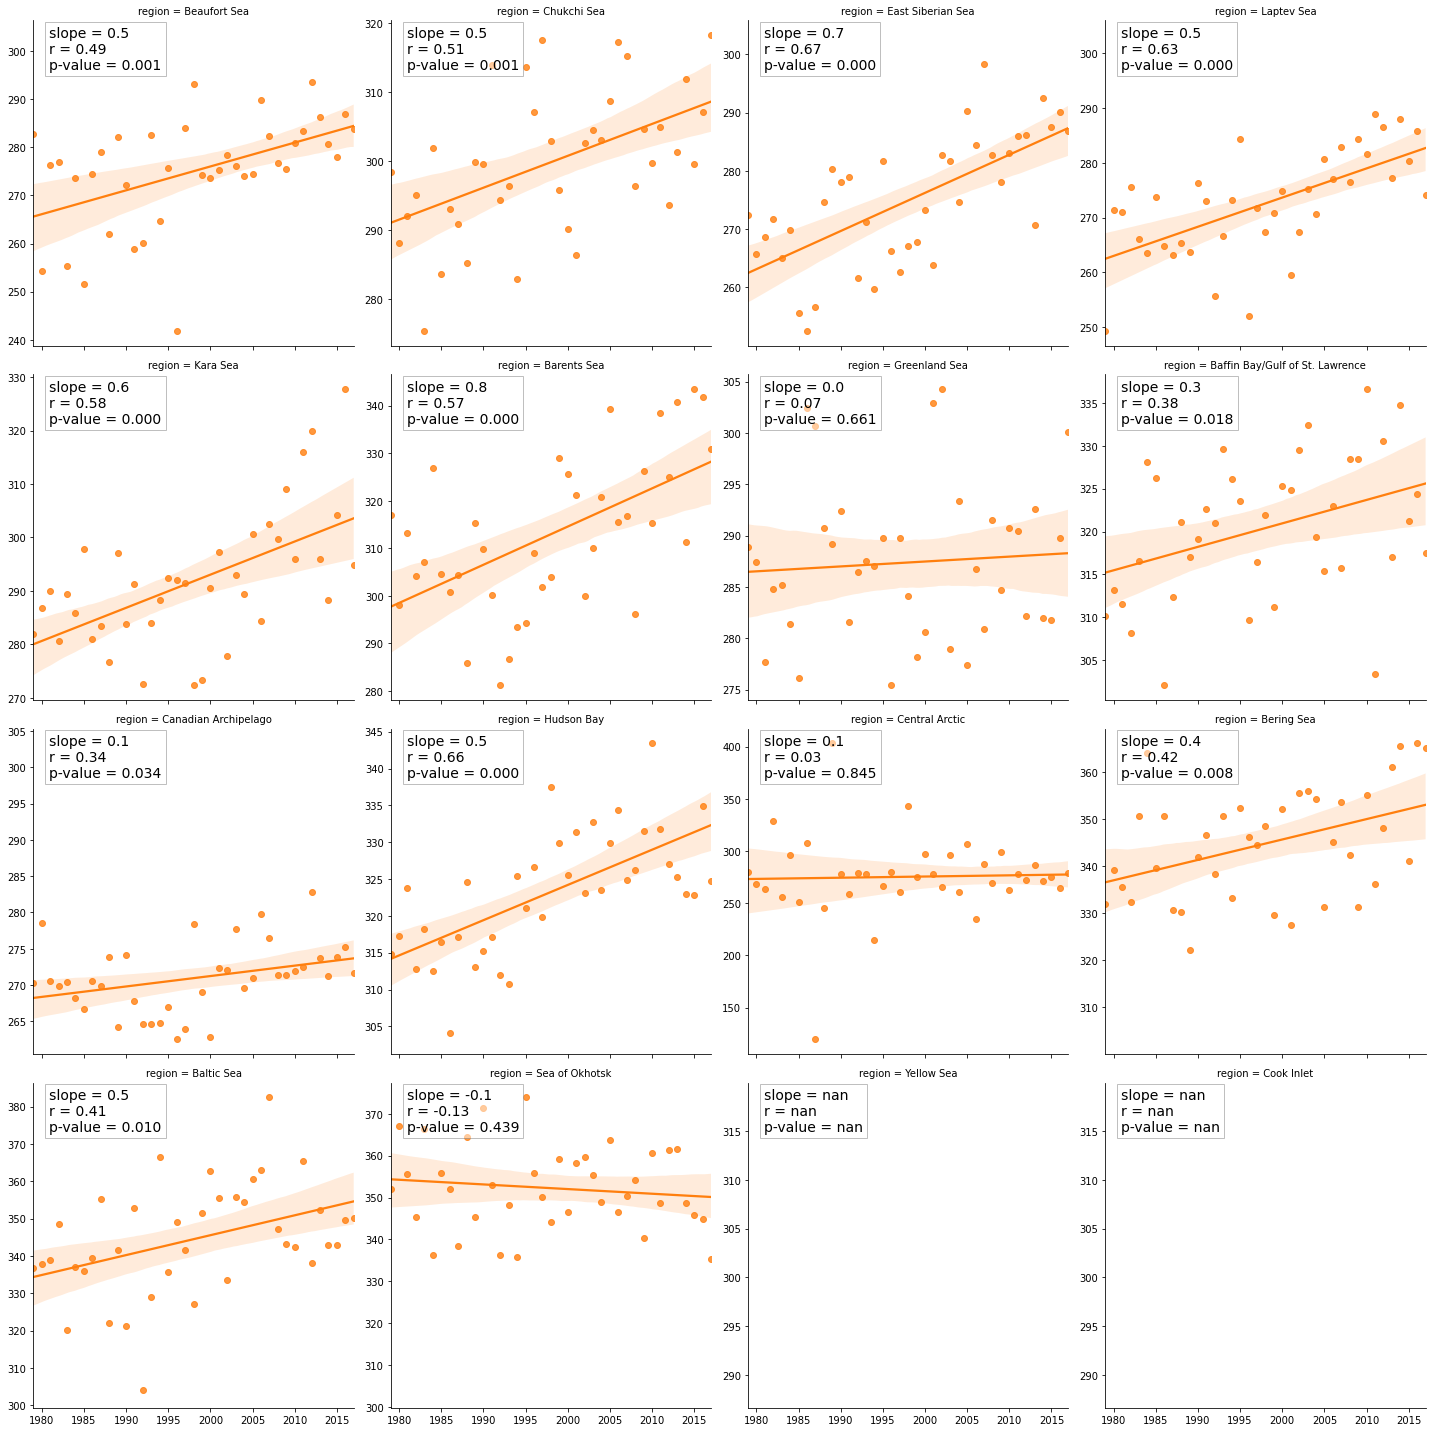

In [621]:
maise_results_df.append(lmplot_maise_with_stats(zs_df, "Steele", "DOA", "#ff7f0e"))

#### Steele Day of Closing

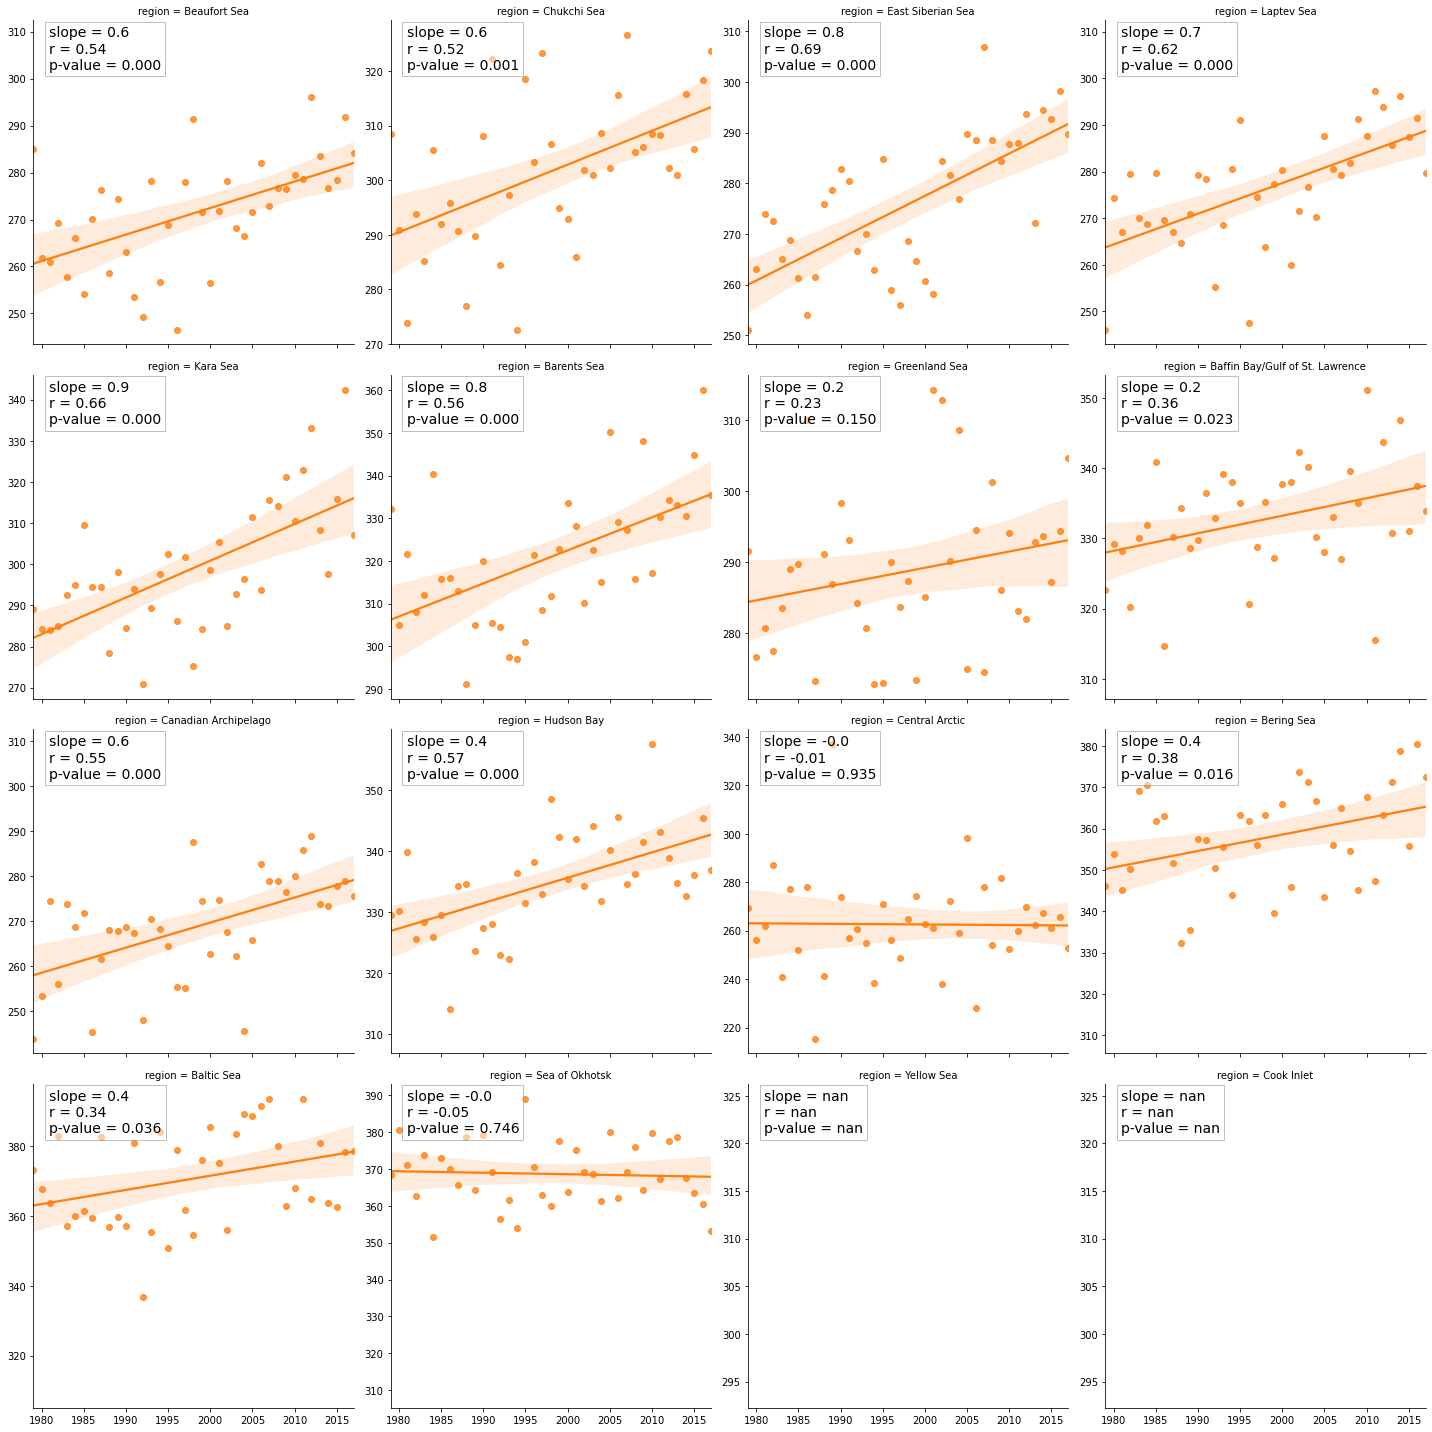

In [622]:
maise_results_df.append(lmplot_maise_with_stats(zs_df, "Steele", "DOC", "#ff7f0e"))

#### Steele Day of Opening

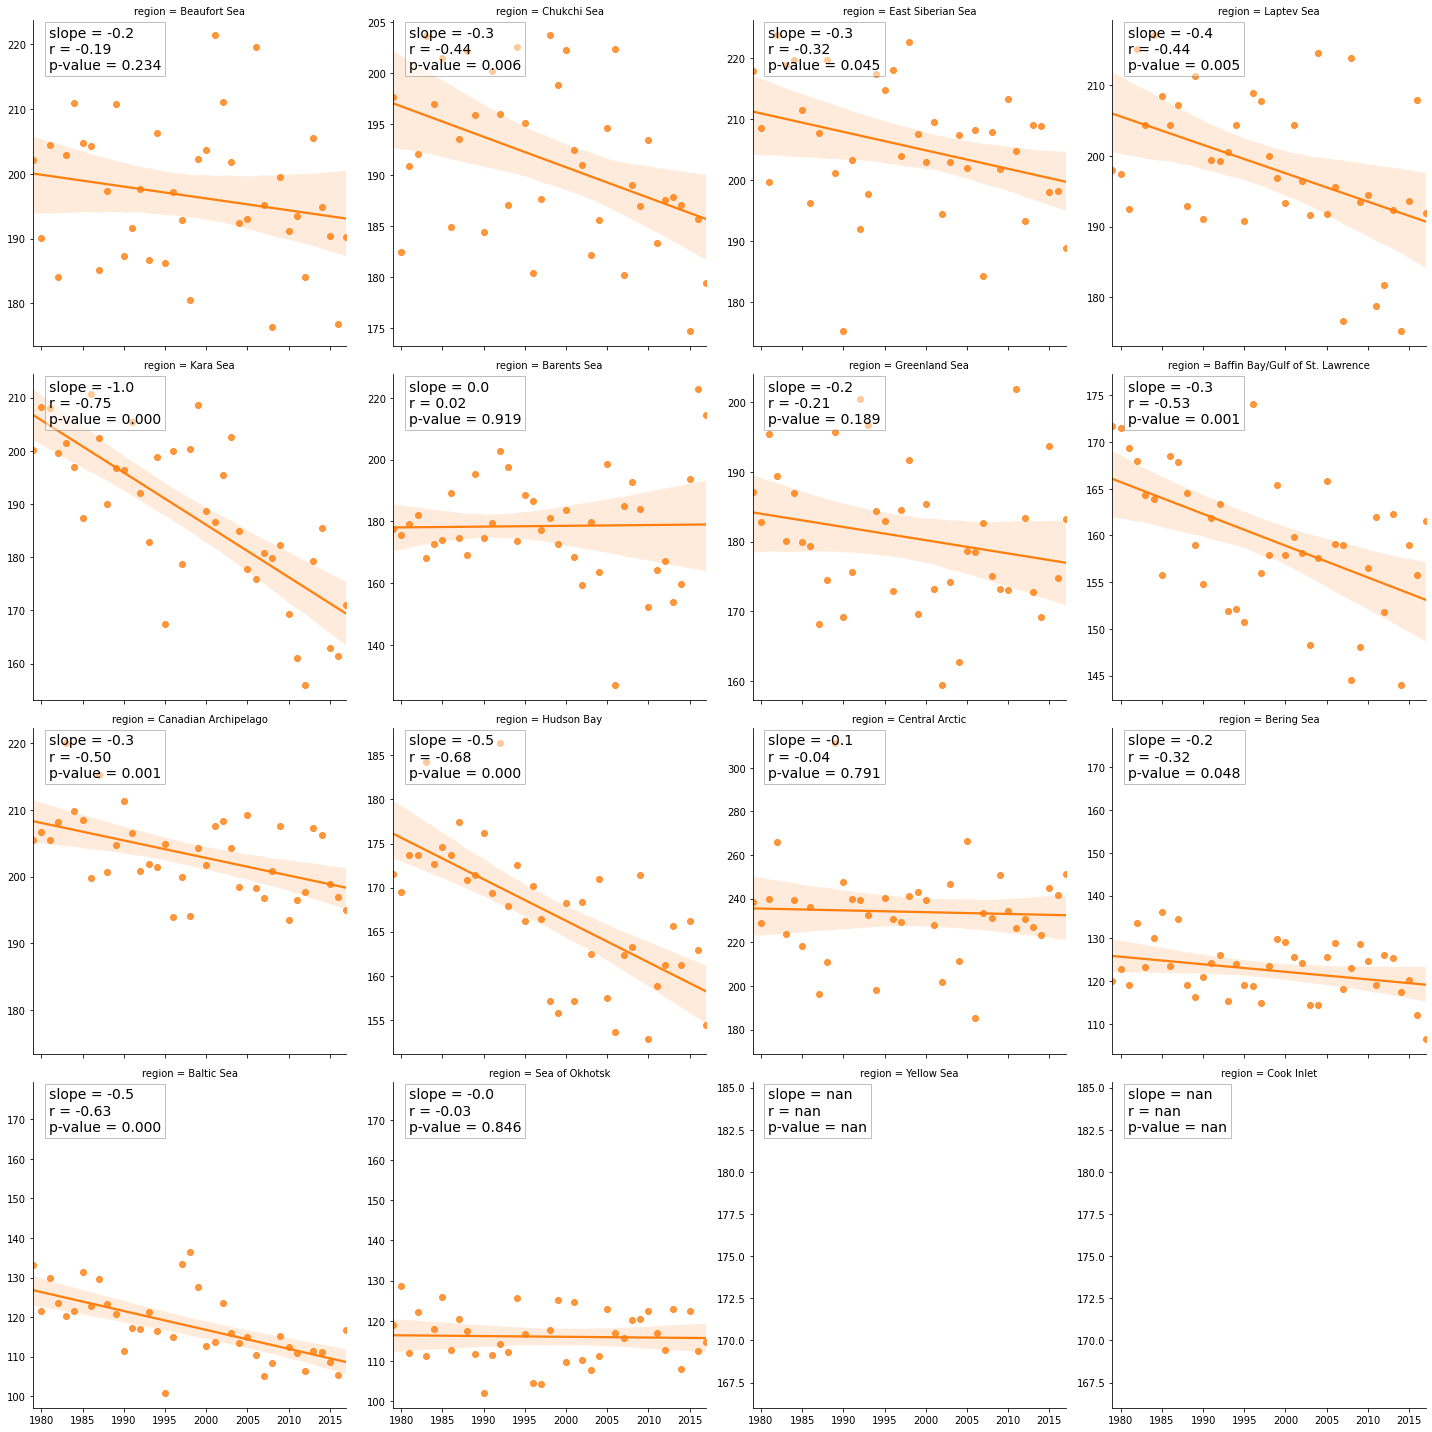

In [623]:
maise_results_df.append(lmplot_maise_with_stats(zs_df, "Steele", "DOO", "#ff7f0e"))

#### Steele Day of Retreat

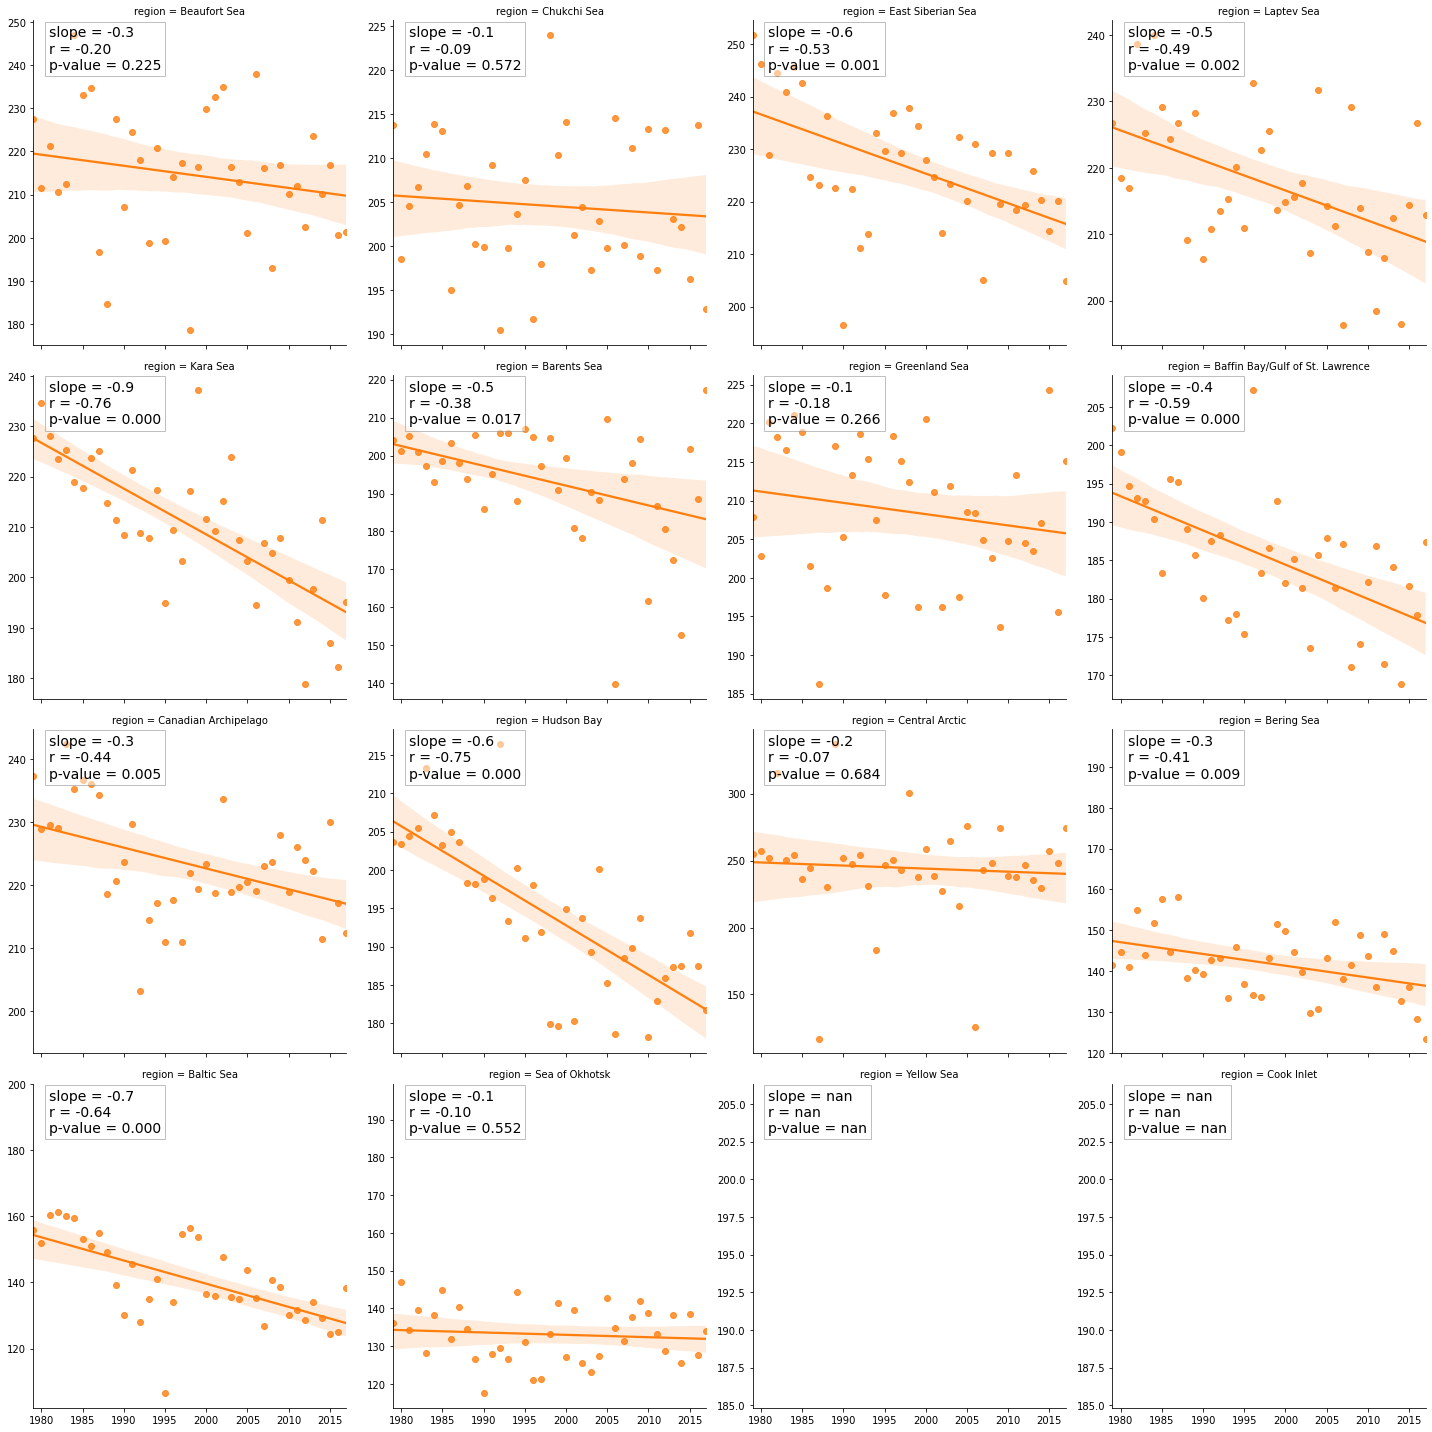

In [624]:
maise_results_df.append(lmplot_maise_with_stats(zs_df, "Steele", "DOR", "#ff7f0e"))

In [626]:
print(pd.concat(maise_results_df).to_string())

                             region   group       indicator  slope  r_squared  p_value
0   Baffin Bay/Gulf of St. Lawrence     J&H  freezeup_start    0.2       0.40    0.012
1                        Baltic Sea     J&H  freezeup_start    0.5       0.65    0.000
2                       Barents Sea     J&H  freezeup_start    0.5       0.49    0.001
3                      Beaufort Sea     J&H  freezeup_start    0.5       0.56    0.000
4                        Bering Sea     J&H  freezeup_start    0.5       0.77    0.000
5              Canadian Archipelago     J&H  freezeup_start    0.2       0.55    0.000
6                    Central Arctic     J&H  freezeup_start   -0.3      -0.14    0.393
7                       Chukchi Sea     J&H  freezeup_start    0.6       0.60    0.000
8                        Cook Inlet     J&H  freezeup_start   -0.0      -0.22    0.179
9                 East Siberian Sea     J&H  freezeup_start    0.6       0.74    0.000
10                    Greenland Sea     J&H